In [67]:
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import functools as ft
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def load_sudoku_images(path, total, device):
    sudoku_img = torch.empty(total,8*28,8*28, device=device)
    transform = transforms.ToTensor()
    for i in tqdm(range(total), 'sudoku images'):
        sudoku_img[i] = transform(Image.open(f'{path}/{i}.png'))
    return sudoku_img

In [4]:
def as_digit_images(sudoku_img):
    return torch.stack(torch.split(
        torch.stack(torch.split(sudoku_img, [28]*8, dim=-2), dim=-3),
        [28]*8, dim=-1), dim=-3)

In [56]:
#sudoku_img = load_sudoku_images('data/query', 10000, device)
#torch.save(sudoku_img, 'data/pt-cache/query_sudoku_img.pt')
#sudoku_img = torch.load('data/pt-cache/query_sudoku_img.pt')

In [57]:
#digit_img = as_digit_images(sudoku_img)
#torch.save(digit_img, 'data/pt-cache/query_digit_img.pt')
digit_img = torch.load('data/pt-cache/query_digit_img.pt')

In [58]:
full_X = digit_img.view(-1,1,28,28)
full_y = torch.load('data/pt-cache/query_y.pt')
class_size = torch.min(torch.bincount(full_y))
bal_X = torch.cat([full_X[full_y==i][:class_size] for i in range(9)])
bal_y = torch.cat([full_y[full_y==i][:class_size] for i in range(9)])
train_X, test_X, train_y, test_y = train_test_split(
    bal_X, bal_y, test_size=10000, stratify=bal_y)

In [59]:
for i in tqdm(range(9), 'digits'):
    for j in tqdm(range(1000), 'samples'):
        transform(test_X[test_y==i][j].cpu()).save(f'data/fid/real/{i}/{j}.png', 'PNG')

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.m1 = nn.Sequential(nn.Linear(100,200), nn.ReLU())
        self.m2 = nn.Sequential(nn.Linear(9,1000), nn.ReLU())
        self.m3 = nn.Sequential(nn.Linear(1200,784), nn.Sigmoid())
        self.d = nn.Dropout(0.5)
        
    def forward(self, Z, Y):
        return self.m3(self.d(torch.cat((self.m1(Z), self.m2(Y)), dim=-1))).view(-1,1,28,28)

In [28]:
def viz_images(img):
    plt.imshow(utils.make_grid(img.detach().cpu(), nrow=9).permute(1,2,0))

In [77]:
gen = Generator()
print(gen.load_state_dict(torch.load('data/pt-cache/bal_gen.71.pt')))
gen = gen.to(device)
gen.train()
X = torch.empty(9,1000,1,28,28, device=device)
with torch.no_grad():
    for i in tqdm(range(9), 'digits'):
        X[i] = gen(torch.rand(1000,100, device=device), F.one_hot(torch.tensor([i]*1000, device=device), num_classes=9).float())

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


In [78]:
def store_images(X, y, path):
    X = X.detach().cpu()
    y = y.detach().cpu()
    c = torch.zeros(torch.max(y)+1, dtype=torch.long)
    transform = transforms.ToPILImage()
    for i in tqdm(range(X.shape[0]), 'samples'):
        transform(X[i]).save(os.path.join(path, f'{y[i].item()}/{c[y[i]].item()}.png'), 'PNG')
        c[y[i]] += 1

In [79]:
store_images(X.view(-1,1,28,28), torch.tensor([[i]*1000 for i in range(9)]).reshape(-1), 'data/fid/fake/')

In [54]:
transform = transforms.ToPILImage()
with torch.no_grad():
    for i in tqdm(range(9), 'digits'):
        X = gen(torch.rand(1000,100, device=device), F.one_hot(torch.tensor([i]*1000, device=device), num_classes=9).float())
        for j in tqdm(range(1000), 'samples'):
            transform(X[j].cpu()).save(f'data/fid/fake/{i}/{j}.png', 'PNG')

In [42]:
transform = transforms.ToPILImage()
transform(gen(torch.rand(1,100), F.one_hot(torch.tensor([4]), num_classes=9).float())[0,...])

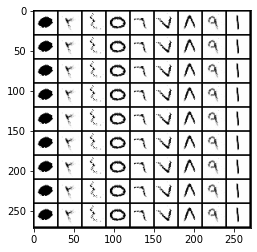

In [36]:
gen.eval()
with torch.no_grad():
    viz_images(gen(torch.rand(81,100), F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8]*9), num_classes=9).float()))